# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


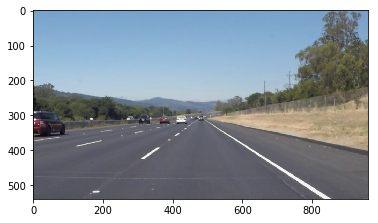

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_x1=500;
    left_x2=500;
    left_y1=0;
    left_y2=0;
    right_x1=500;
    right_x2=500;
    right_y1=0;
    right_y2=0;
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            #slope is positive, left line
            if(slope>0):
                if(x1<left_x1): 
                    left_x1=x1;
                    
                if(x2<left_x2): 
                    left_x2=x2
                    
                if(y1>left_y1): 
                    left_y1=y1
                    
                if(y2<left_y2): 
                    left_y2=y2;                
                
            #slope is negative, right line
            else:
                if(x1>right_x1): 
                    right_x1=x1
                    
                if(x2>right_x2): 
                    right_x2=x2
                    
                if(y1>right_y1): 
                    right_y1=y1
                    
                if(y2<right_y2): 
                    right_y2=y2
                    
        avg_slope_left = ((left_y2-left_y1)/(left_x2-left_x1))
        avg_slope_right = ((right_y2-right_y1)/(right_x2-right_x1))
        
        #Only make a change if the line doesn't already go to the edge of the screen            
        
            
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['.DS_Store',
 'Screen Shot 2017-03-22 at 5.51.04 PM.png',
 'Screen Shot 2017-03-22 at 5.51.19 PM.png',
 'Screen Shot 2017-03-22 at 5.51.39 PM.png',
 'solidWhiteCurve.jpg',
 'solidWhiteCurve_processed.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

698.532994924
42.5096153846


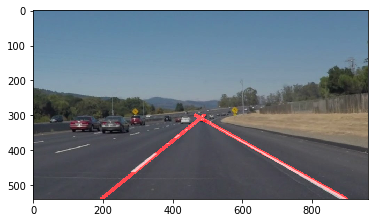

In [95]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

image = mpimg.imread('test_images/solidWhiteCurve.jpg')
gray = grayscale(image)

blur_gray = gaussian_blur(gray, 3)

low_threshold = 75
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

plt.imshow(edges, cmap='Greys_r')

mask = np.zeros_like(edges)   
ignore_mask_color = 255  

imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 320), (490, 300), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

rho = 2 
theta = np.pi/180 
threshold = 100     
min_line_length = 50 
max_line_gap = 20    
line_image = np.copy(image)*0 

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

right_x1=700;
right_x2=700;
right_y1=400;
right_y2=400;
    
left_x1=300;
left_x2=300;    
left_y1=400;
left_y2=400;

left_avg_slope = -0.7
right_avg_slope = 0.7
    
for line in lines:
    for x1,y1,x2,y2 in line:
        slope = ((y2-y1)/(x2-x1))
        #slope is positive with given origin, right line; right line working
        if(slope>0):
            if(x1<right_x1): 
                right_x1=x1
                     
            if(x2>right_x2):
                right_x2=x2
                    
            if(y1<right_y1): 
                right_y1=y1
                    
            if(y2>right_y2): 
                right_y2=y2;
        #slope is negative with given origin, left line
        else:
            if(x1<left_x1): 
                left_x1=x1
                    
            if(x2>left_x2): 
                left_x2=x2
                    
            if(y1>left_y1): 
                left_y1=y1
                        
            if(y2<left_y2): 
                left_y2=y2
                
                
right_slope = ((right_y2-right_y1)/(right_x2-right_x1))
left_slope = ((left_y2-left_y1)/(left_x2-left_x1))

right_intercept = -1*right_slope*right_x1+right_y1
left_intercept = -1*left_slope*left_x1+left_y1

right_y2_final = 300;
right_y1_final = 540;
right_x2_final = int((right_y2_final-right_intercept)/right_slope)
right_x1_final = int((right_y1_final-right_intercept)/right_slope)

left_y2_final = 300;
left_y1_final = 540;
left_x2_final = int((left_y2_final-left_intercept)/left_slope)
left_x1_final = int((left_y1_final-left_intercept)/left_slope)

cv2.line(line_image,(left_x1_final,left_y1_final),(left_x2_final,left_y2_final),(255,0,0),10)           
cv2.line(line_image,(right_x1_final,right_y1_final),(right_x2_final,right_y2_final),(255,0,0),10)
        
color_edges = np.dstack((edges, edges, edges)) 

lines_image = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(lines_image)

plt.savefig('test_images/solidWhiteCurve_processed.jpg')


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [114]:
def process_image(image):
    gray = grayscale(image)

    blur_gray = gaussian_blur(gray, 3)

    low_threshold = 75
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    mask = np.zeros_like(edges)   
    ignore_mask_color = 255  

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (490, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    rho = 2 
    theta = np.pi/180 
    threshold = 100     
    min_line_length = 50 
    max_line_gap = 20    
    line_image = np.copy(image)*0 

    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    right_x1=700;
    right_x2=700;
    right_y1=400;
    right_y2=400;
    
    left_x1=300;
    left_x2=300;    
    left_y1=400;
    left_y2=400;

    left_avg_slope = -0.75
    right_avg_slope = 0.67
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            #slope is positive with given origin, right line; right line working
            if(slope>0):
                if(x1<right_x1): 
                    right_x1=x1
                     
                if(x2>right_x2):
                    right_x2=x2
                    
                if(y1<right_y1): 
                    right_y1=y1
                    
                if(y2>right_y2): 
                    right_y2=y2;
            #slope is negative with given origin, left line
            else:
                if(x1<left_x1): 
                    left_x1=x1
                    
                if(x2>left_x2): 
                    left_x2=x2
                    
                if(y1>left_y1): 
                    left_y1=y1
                        
                if(y2<left_y2): 
                    left_y2=y2
                
    if(left_x2-left_x1==0): left_x2+=1;
    if(right_x2-right_x1==0): right_x2+=1;
        
    right_slope = ((right_y2-right_y1)/(right_x2-right_x1))
    left_slope = ((left_y2-left_y1)/(left_x2-left_x1))

    if(abs(right_slope-right_avg_slope)>0.1): right_slope = right_avg_slope
    else: right_avg_slope = (right_avg_slope*2+right_slope)/3
            #weighted average if the slope is reasonable allows improvements over time
            
    if(abs(left_slope-left_avg_slope)>0.1): left_slope = left_avg_slope
    else: left_avg_slope = (left_avg_slope*2+left_slope)/3
            #weighted average if the slope is reasonable allows improvements over time
    
    '''right_intercept_avg = 15;
    right_intercept = -1*right_slope*(right_x1+right_x2)/2+(right_y1+right_y2)/2
   
    if(abs(right_intercept-right_intercept_avg)>2): right_intercept = right_intercept_avg
    else: right_intercept_avg = (right_intercept_avg*2+right_intercept)/3
            #weighted average if the intercept is reasonable allows improvements over time
            
    left_intercept_avg = 650;
    left_intercept = -1*left_slope*(left_x1+left_x2)/2+(left_y1+left_y2)/2
    print(left_intercept)
    
    if(abs(left_intercept-left_intercept_avg)>10): left_intercept = left_intercept_avg
    else: left_intercept_avg = (left_intercept_avg*2+left_intercept)/3
            #weighted average if the intercept is reasonable allows improvements over time'''
    

    right_y2_final = 300;
    right_y1_final = 540;
    right_x2_final = int((right_y2_final-right_intercept)/right_slope)
    right_x1_final = int((right_y1_final-right_intercept)/right_slope)

    left_y2_final = 300;
    left_y1_final = 540;
    left_x2_final = int((left_y2_final-left_intercept)/left_slope)
    left_x1_final = int((left_y1_final-left_intercept)/left_slope)
    
    cv2.line(line_image,(left_x1_final,left_y1_final),(left_x2_final,left_y2_final),(255,0,0),10)           
    cv2.line(line_image,(right_x1_final,right_y1_final),(right_x2_final,right_y2_final),(255,0,0),10)
        
    color_edges = np.dstack((edges, edges, edges)) 

    lines_image = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    return lines_image

Let's try the one with the solid white lane on the right first ...

In [115]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

647.950166113
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4






  0%|          | 0/222 [00:00<?, ?it/s]



  1%|▏         | 3/222 [00:00<00:08, 25.25it/s]

647.950166113
645.174698795
644.621301775
642.296187683
646.375


645.75






  3%|▎         | 7/222 [00:00<00:08, 26.38it/s]



  5%|▍         | 11/222 [00:00<00:07, 28.58it/s]

645.75
644.25
645.75
656.015625
644.515555556
643.538461538
642.618421053
638.498542274






  7%|▋         | 15/222 [00:00<00:06, 30.58it/s]



  9%|▊         | 19/222 [00:00<00:06, 32.65it/s]

638.487654321
633.927272727
625.375
644.75
645.75
646.375
647.625
635.980099502
638.130044843






 11%|█         | 24/222 [00:00<00:05, 34.59it/s]

638.162790698
640.2
634.918367347
636.114942529






 13%|█▎        | 28/222 [00:00<00:05, 33.40it/s]

636.265895954
647.125
646.0






 14%|█▍        | 32/222 [00:00<00:05, 33.03it/s]

646.75
645.5
645.75
645.571428571






 16%|█▌        | 36/222 [00:01<00:05, 33.12it/s]

650.8
675.096774194
644.263345196






 18%|█▊        | 40/222 [00:01<00:05, 33.03it/s]

640.472140762
636.0
638.536585366
643.625






 20%|██        | 45/222 [00:01<00:05, 34.66it/s]

645.25
646.875
644.75
645.75


636.976331361
641.842105263
639.489361702






 22%|██▏       | 49/222 [00:01<00:07, 24.51it/s]



 23%|██▎       | 52/222 [00:01<00:06, 25.37it/s]

637.8125
634.5
635.865625
632.482352941






 25%|██▍       | 55/222 [00:01<00:07, 22.28it/s]

644.75
646.5
646.0
646.0
646.125
623.724137931





 26%|██▌       | 58/222 [00:02<00:07, 21.83it/s]



 27%|██▋       | 61/222 [00:02<00:07, 21.35it/s]


642.876190476
626.957528958
627.470779221
625.48189415
628.294617564
626.211699164






 29%|██▉       | 64/222 [00:02<00:07, 21.71it/s]



 30%|███       | 67/222 [00:02<00:07, 21.27it/s]

646.0
645.75
646.125
646.125






 32%|███▏      | 70/222 [00:02<00:07, 19.38it/s]

647.125
657.75






 33%|███▎      | 73/222 [00:02<00:09, 15.48it/s]

623.0
621.8
619.983443709
621.599439776
619.409972299






 34%|███▍      | 75/222 [00:03<00:09, 16.28it/s]



 35%|███▍      | 77/222 [00:03<00:08, 17.03it/s]



 36%|███▌      | 79/222 [00:03<00:08, 17.20it/s]

617.837209302
644.625
646.25
646.25






 36%|███▋      | 81/222 [00:03<00:09, 14.93it/s]

645.625
646.25
655.875
649.625






 37%|███▋      | 83/222 [00:03<00:09, 14.37it/s]



 38%|███▊      | 85/222 [00:03<00:12, 11.19it/s]

651.5
644.116666667
630.898876404
626.630434783






 39%|███▉      | 87/222 [00:04<00:11, 11.76it/s]



 40%|████      | 89/222 [00:04<00:10, 12.50it/s]



 41%|████      | 91/222 [00:04<00:09, 13.86it/s]

647.25
645.25
645.875
647.125






 42%|████▏     | 93/222 [00:04<00:10, 12.20it/s]

647.5
647.5
658.5






 43%|████▎     | 95/222 [00:04<00:09, 13.01it/s]



 44%|████▎     | 97/222 [00:04<00:09, 12.80it/s]

657.75
654.75
653.875






 45%|████▍     | 99/222 [00:04<00:08, 14.20it/s]



 45%|████▌     | 101/222 [00:04<00:08, 14.81it/s]

635.714285714
646.875
647.625
647.5
646.25






 46%|████▋     | 103/222 [00:05<00:07, 15.69it/s]



 47%|████▋     | 105/222 [00:05<00:06, 16.73it/s]

648.5
646.125
647.625
620.8






 48%|████▊     | 107/222 [00:05<00:06, 17.10it/s]



 49%|████▉     | 109/222 [00:05<00:06, 17.60it/s]

659.5
623.543307087
627.46975089
629.34870317






 50%|█████     | 111/222 [00:05<00:06, 16.56it/s]



 51%|█████     | 113/222 [00:05<00:06, 16.75it/s]

625.459537572
627.542134831
627.92
645.375






 52%|█████▏    | 115/222 [00:05<00:07, 15.07it/s]

647.625
647.125
647.125





 53%|█████▎    | 117/222 [00:05<00:07, 13.75it/s]



 54%|█████▎    | 119/222 [00:06<00:07, 14.28it/s]


660.0
628.423076923
630.012345679
627.472027972






 55%|█████▍    | 122/222 [00:06<00:06, 15.72it/s]



 56%|█████▋    | 125/222 [00:06<00:05, 17.56it/s]

630.089552239
624.774373259
625.002770083
648.0
649.0






 58%|█████▊    | 128/222 [00:06<00:05, 18.37it/s]



 59%|█████▉    | 131/222 [00:06<00:04, 19.96it/s]

648.5
648.0
647.625
627.4375
637.666666667






 60%|██████    | 134/222 [00:06<00:04, 19.66it/s]

636.866108787
639.660377358
641.345565749
636.798850575
634.750716332






 62%|██████▏   | 137/222 [00:06<00:04, 20.53it/s]



 63%|██████▎   | 140/222 [00:07<00:03, 21.10it/s]

646.25
645.875
647.125
647.25
648.75






 64%|██████▍   | 143/222 [00:07<00:03, 21.30it/s]

648.125
642.145631068
668.641975309
643.884758364
648.006622517






 66%|██████▌   | 146/222 [00:07<00:03, 21.62it/s]



 67%|██████▋   | 149/222 [00:07<00:03, 22.17it/s]

647.298192771
644.579881657
642.947214076
648.75
646.375
647.25






 68%|██████▊   | 152/222 [00:07<00:03, 22.11it/s]



 70%|██████▉   | 155/222 [00:07<00:03, 19.65it/s]

648.0
647.5
651.732673267
649.157894737






 71%|███████   | 158/222 [00:07<00:03, 19.23it/s]



 73%|███████▎  | 161/222 [00:08<00:02, 20.93it/s]

646.754863813
654.365384615
649.5
651.682926829
651.365558912
645.5






 74%|███████▍  | 164/222 [00:08<00:02, 20.54it/s]



 75%|███████▌  | 167/222 [00:08<00:02, 21.79it/s]

646.125
649.125
648.375
648.875
664.3125






 77%|███████▋  | 170/222 [00:08<00:02, 22.26it/s]

665.764976959
672.483606557
673.856164384
670.810897436
672.851132686
672.522727273






 78%|███████▊  | 173/222 [00:08<00:02, 23.04it/s]



 79%|███████▉  | 176/222 [00:08<00:02, 22.76it/s]

647.375
648.375
651.75
647.75
646.75






 81%|████████  | 179/222 [00:08<00:01, 22.77it/s]



 82%|████████▏ | 182/222 [00:08<00:01, 23.06it/s]

659.333333333
693.459459459
678.037974684
683.021978022
678.379537954
679.046822742
677.755033557






 83%|████████▎ | 185/222 [00:09<00:01, 23.66it/s]



 85%|████████▍ | 188/222 [00:09<00:01, 23.44it/s]

646.375
646.125
647.5
645.375
645.5
657.818181818






 86%|████████▌ | 191/222 [00:09<00:01, 23.60it/s]



 87%|████████▋ | 194/222 [00:09<00:01, 23.35it/s]



 89%|████████▊ | 197/222 [00:09<00:01, 24.65it/s]

671.125603865
665.0
677.410714286
672.796116505
670.929487179
672.935483871






 90%|█████████ | 200/222 [00:09<00:00, 23.09it/s]

646.0
645.5
651.375
645.875
646.375
663.465968586






 91%|█████████▏| 203/222 [00:09<00:00, 23.62it/s]



 93%|█████████▎| 206/222 [00:10<00:00, 23.22it/s]



 94%|█████████▍| 209/222 [00:10<00:00, 23.48it/s]

674.333333333
664.125
674.467741935
650.625
672.288194444
674.772727273






 95%|█████████▌| 212/222 [00:10<00:00, 22.42it/s]

646.125
646.5
647.625
648.125
648.0
660.75






 97%|█████████▋| 215/222 [00:10<00:00, 23.17it/s]



 98%|█████████▊| 218/222 [00:10<00:00, 23.01it/s]

669.404761905
676.133333333
676.0
674.646302251
692.259124088






100%|█████████▉| 221/222 [00:10<00:00, 21.88it/s]





646.0
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.53 s, sys: 1.49 s, total: 6.02 s
Wall time: 11.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4






  0%|          | 0/682 [00:00<?, ?it/s]



  0%|          | 2/682 [00:00<00:38, 17.64it/s]



  1%|          | 5/682 [00:00<00:34, 19.79it/s]



  1%|          | 8/682 [00:00<00:31, 21.44it/s]



  2%|▏         | 11/682 [00:00<00:29, 22.70it/s]



  2%|▏         | 14/682 [00:00<00:28, 23.11it/s]



  2%|▏         | 17/682 [00:00<00:27, 24.08it/s]



  3%|▎         | 20/682 [00:00<00:35, 18.84it/s]



  3%|▎         | 22/682 [00:01<00:49, 13.36it/s]



  4%|▎         | 24/682 [00:01<00:53, 12.30it/s]



  4%|▍         | 26/682 [00:01<00:52, 12.57it/s]



  4%|▍         | 28/682 [00:01<00:50, 13.08it/s]



  4%|▍         | 30/682 [00:01<00:48, 13.50it/s]



  5%|▍         | 32/682 [00:01<00:47, 13.56it/s]



  5%|▌         | 35/682 [00:02<00:42, 15.25it/s]



  5%|▌         | 37/682 [00:02<00:39, 16.23it/s]



  6%|▌         | 40/682 [00:02<00:34, 18.61it/s]



  6%|▋         | 43/682 [00:02<00:32, 19.60it/s]



  7%|▋         | 46/682 [00:02<00:31, 19.99it/s]



  7%|▋         | 49/

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 23.9 s, sys: 8.71 s, total: 32.6 s
Wall time: 2min 11s


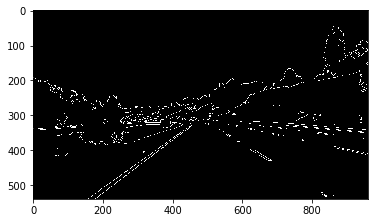

In [91]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [92]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4






  0%|          | 0/251 [00:00<?, ?it/s]



  0%|          | 1/251 [00:00<00:34,  7.28it/s]



  1%|          | 2/251 [00:00<00:38,  6.45it/s]



  2%|▏         | 4/251 [00:00<00:32,  7.58it/s]



  2%|▏         | 6/251 [00:00<00:27,  8.83it/s]



  3%|▎         | 8/251 [00:00<00:24,  9.76it/s]



  4%|▍         | 10/251 [00:00<00:23, 10.35it/s]



  5%|▍         | 12/251 [00:01<00:27,  8.60it/s]



  5%|▌         | 13/251 [00:01<00:33,  7.21it/s]



  6%|▌         | 14/251 [00:01<00:36,  6.51it/s]



  6%|▌         | 15/251 [00:01<00:33,  7.07it/s]



  7%|▋         | 17/251 [00:01<00:28,  8.07it/s]



  8%|▊         | 19/251 [00:02<00:25,  8.99it/s]



  8%|▊         | 21/251 [00:02<00:23,  9.87it/s]



  9%|▉         | 23/251 [00:02<00:23,  9.66it/s]



 10%|▉         | 25/251 [00:02<00:25,  9.04it/s]



 10%|█         | 26/251 [00:02<00:26,  8.49it/s]



 11%|█         | 27/251 [00:02<00:27,  8.28it/s]



 12%|█▏        | 29/251 [00:03<00:24,  9.22it/s]



 12%|█▏        | 30/25

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 17.7 s, sys: 4.07 s, total: 21.8 s
Wall time: 41.5 s


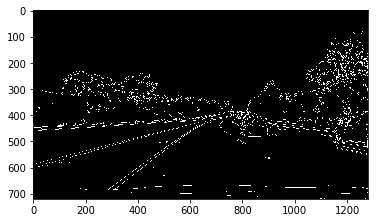

In [93]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [94]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))